In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
matplotlib.style.use('ggplot')

In [ ]:
!pwd

/content/drive/My Drive/Colab Notebooks/GIT/Airline


In [ ]:
cd /content/drive/MyDrive/Colab Notebooks/GIT/Airline

/content/drive/MyDrive/Colab Notebooks/GIT/Airline


In [ ]:
def errors(actual,prediction):

    m=keras.metrics.MeanAbsolutePercentageError()
    n=keras.metrics.MeanAbsoluteError()

    m.update_state(actual,prediction)
    n.update_state(actual,prediction)

    error=m.result().numpy() #  MAPE   
    error1=n.result().numpy() # MAE

    return ({'MAE':error1 ,'MAPE':error})

Exploring train Data

In [ ]:
df = pd.read_csv('international-airline-passengers.csv')

In [ ]:
df.drop(df.index[144],inplace=True)

df['Month']=pd.to_datetime(df['Month'])

In [ ]:
type(df['Month'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [ ]:
df.columns=['Month','Nop']

#NOP= No of Passengers

In [ ]:
df.head()

,Month,Nop
0,1949-01-01,112.0
1,1949-02-01,118.0
2,1949-03-01,132.0
3,1949-04-01,129.0
4,1949-05-01,121.0


Text(0, 0.5, 'No. of Passangers')

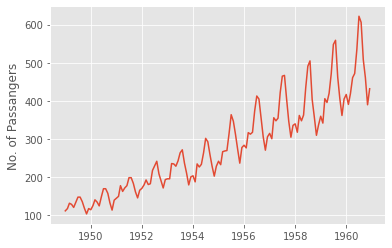

In [ ]:
plt.plot(df['Month'],df['Nop'])
plt.ylabel('No. of Passangers')

# Test-Train Split

In [ ]:
df_train = df[:-24]

In [ ]:
df_test=df[-24:]

In [ ]:
trainset=df_train.iloc[:,1:] # only taking the NOP(No.of passangers) column

In [ ]:
trainset.head()

,Nop
0,112.0
1,118.0
2,132.0
3,129.0
4,121.0


In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
training_scaled = sc.fit_transform(trainset)

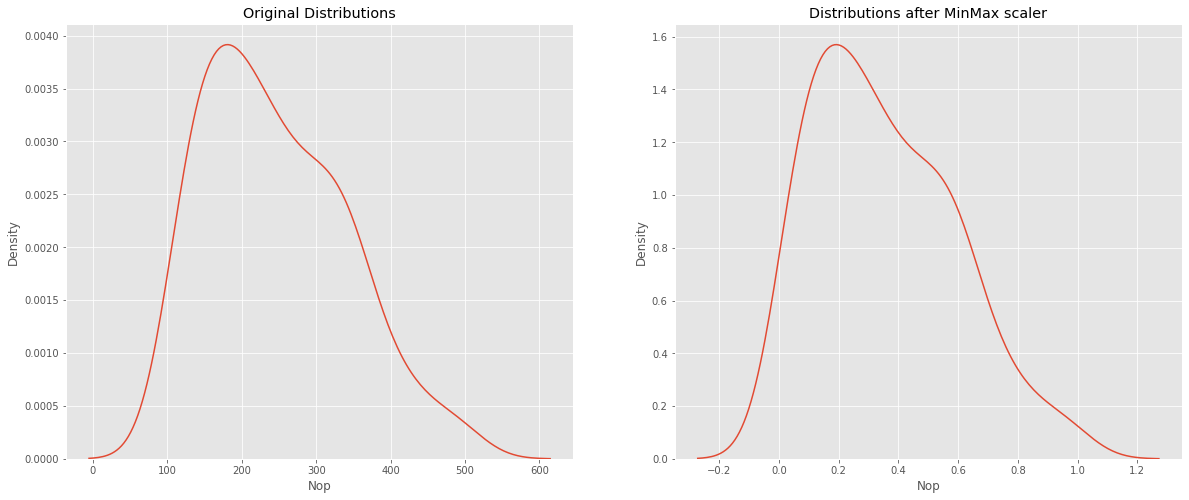

In [ ]:
fig, (ax0,ax1) = plt.subplots(ncols=2, figsize=(20,8))
ax0.set_title('Original Distributions')
ax1.set_title('Distributions after MinMax scaler')
sns.kdeplot(df_train['Nop'], ax=ax0)
sns.kdeplot(pd.DataFrame(training_scaled,columns=['Nop'])['Nop'], ax=ax1)

In [ ]:
import tensorflow as tf
keras=tf.keras    
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [ ]:
window_max=4 
# is the sliding window size # Tune this Hyper-parameter #  It's a monthly dataset

trainError_MAPE=[]
testError_MAPE=[]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 4, 50)             10400     
_________________________________________________________________
dropout (Dropout)            (None, 4, 50)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 4, 50)             20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 50)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 5

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


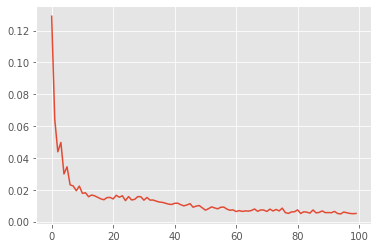

train_errors: {'MAE': 20.66651, 'MAPE': 8.755527}


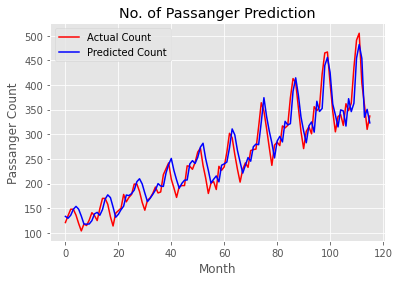

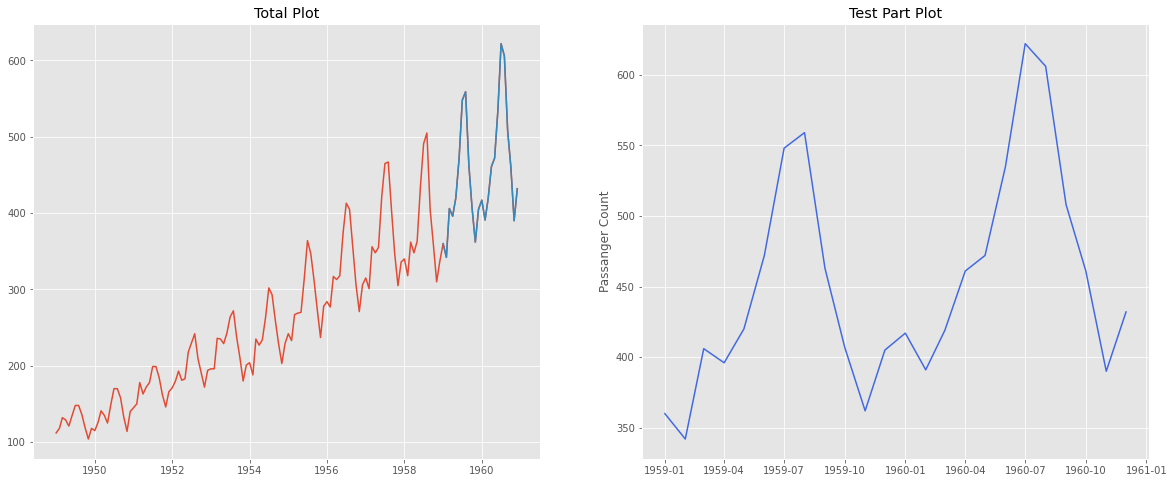

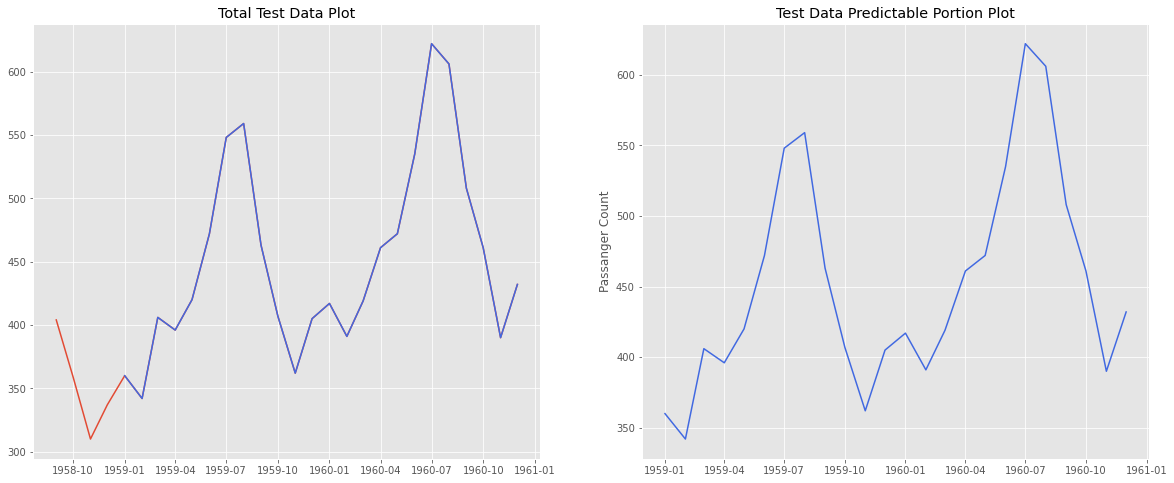

test_errors: {'MAE': 39.426643, 'MAPE': 8.762648}


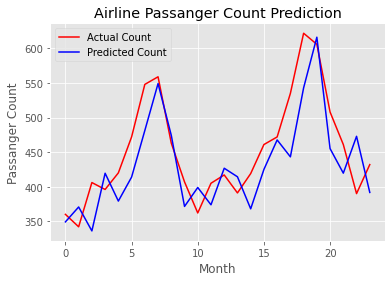

window: 4
train_MAPE: 8.755527
test_MAPE: 8.762648


In [ ]:
for window in range(4,window_max+1):
#     window=window_max # use when the for loop is disabled
    
    # Preparing the training data for LSTM
    
    x_train = []
    y_train = []

    # %% [code]
    for i in range(window,len(df_train)):
        x_train.append(training_scaled[i-window:i, 0])
        y_train.append(training_scaled[i,0])
    x_train,y_train = np.array(x_train),np.array(y_train)

    # %% [code]
    x_train.shape # first dim= trainset[first dim] - windowsize

    # %% [code]
    y_train.shape # Same first dim as X_train

    # %% [code]


    # %% [code]
    # Converting to the Dimensions: (N=len(trainset)-window+1) * (T=window) * (D=1), 
    #explicitly before feeding it to LSTM
    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))


    # %% [code]
    keras.backend.clear_session()
    tf.random.set_seed(2020)
    #np.random.seed(2020)



    # %% [code]
    regressor = Sequential()
    regressor.add(LSTM(units = 50,return_sequences = True,input_shape = (x_train.shape[1],1)))
    regressor.add(Dropout(0.2))

    # %% [code]
    regressor.add(LSTM(units = 50,return_sequences = True))
    regressor.add(Dropout(0.2))

    # %% [code]
    # regressor.add(LSTM(units = 50,return_sequences = True)) # Activate it to see effect
    # regressor.add(Dropout(0.2))

    # %% [code]
    regressor.add(LSTM(units = 50))
    regressor.add(Dropout(0.2))

    # %% [code]
    regressor.add(Dense(units = 1)) # only one output for regression value with NO Activation Function

    # %% [code]
    regressor.summary()

    # %% [code]
#     lr_schedule = keras.callbacks.LearningRateScheduler(   
#         lambda epoch: 1e-7 * 10**(epoch / 20))

    # activate this code during lr tuning

    # %% [code]
#     opt = keras.optimizers.Adam(lr=1e-7) # use this code during lr tuning
    opt = keras.optimizers.Adam(lr=0.5e-2) # disable this code during lr tuning

    # lr=0.5e-2,set by hyper-paramters tuning

    # %% [code]
    regressor.compile(optimizer = opt, loss = 'mse',metrics=['mae','mape'])

    # %% [code]
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',mode='min',patience=20)

    # %% [code]
    mc = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='loss', mode='min', verbose=0, save_best_only=True)

    # %% [code]
#     hist = regressor.fit(x_train, y_train, epochs=150, batch_size=32,callbacks=[mc, lr_schedule,early_stopping])
    hist = regressor.fit(x_train, y_train, epochs=100, batch_size=32,callbacks=[mc,early_stopping],verbose=0) 
    # lr_schedule removed after lr value is set to 0.5e-02

    # %% [code]
    hist.history.keys()

    # %% [code]
    plt.plot(hist.history['loss'])
    plt.show()

#     %% [code]
#     ##use this part during lr design only
#     plt.semilogx(hist.history["lr"], hist.history["loss"])
#     #plt.ylim=(0.001,0)
# #     plt.plot(hist.history["lr"], hist.history["loss"])
#     #plt.axis([1e-7, 1e-4, 0, 30])
#     plt.show()

    # %% [code]
    from keras.models import load_model
    regressor=load_model('best_model.h5')

    # %% [code]
    prediction_train=regressor.predict(x_train)

    # %% [code]
    prediction_train = sc.inverse_transform(prediction_train)
    #prediction_train

    # %% [code]
    prediction_train.shape

    # %% [code]
    #y_train

    # %% [code]
    y_train=sc.inverse_transform(y_train.reshape(-1,1))

    # %% [code]
    y_train.shape

    # %% [code]
    #metrics= regressor.evaluate(x_train,y_train)

    # %% [code]
    #metrics

    # %% [code]
    train_errors=errors(y_train,prediction_train)
    print('train_errors:',train_errors)

    # %% [code]
    plt.plot(y_train,color = 'red', label = 'Actual Count')
    plt.plot(prediction_train, color = 'blue', label = 'Predicted count')
    plt.title('No. of Passanger Prediction')
    plt.xlabel('Month')
    plt.ylabel('Passanger Count')
    #plt.legend()
    plt.legend(['Actual Count', 'Predicted Count'], loc='upper left')
    plt.show()

    # %% [code]
    df_test.head() 

    # %% [code]
    df_test.tail()  

    # %% [code]
    fig, (ax0,ax1) = plt.subplots(ncols=2, figsize=(20, 8))
    ax0.set_title('Total Plot')
    ax1.set_title('Test Part Plot')
    ax0.plot(df['Month'], df['Nop'])
    ax0.plot(df_test['Month'], df_test['Nop'])
    ax1.plot(df_test['Month'], df_test['Nop'],color='royalblue')
    plt.ylabel('Passanger Count')
    plt.show()

    # %% [code]
    # inputs = df[len(df) - len(df_test)-window:] # alternative way of calculating
    #inputs.head()

    # %% [code]
    df_test.shape

    # %% [code]
    inputs=pd.concat((df_train[-(window):],df_test),axis=0,ignore_index=True)

    # %% [code]
    df['Month'][df_train.index[-1]]

    # %% [code]
    #inputs

    # %% [code]
    inputs.shape

    # %% [code]
    fig, (ax0,ax1) = plt.subplots(ncols=2, figsize=(20, 8))
    ax0.set_title('Total Test Data Plot')
    ax1.set_title('Test Data Predictable Portion Plot')
    #ax0.plot(data_total['Date'], data_total['Open'])
    ax0.plot(inputs['Month'], inputs['Nop'])
    ax0.plot(df_test['Month'], df_test['Nop'],color='royalblue')
    ax1.plot(df_test['Month'], df_test['Nop'],color='royalblue')
    plt.ylabel('Passanger Count')
    plt.show()

    # %% [code]
    testset=inputs['Nop'].values

    # %% [code]
    testset = testset.reshape(-1,1)

    # %% [code]
    testset_scaled = sc.transform(testset)
    testset_scaled.shape

    # %% [code]
    x_test=[]
    y_test=[]

    # %% [code]
    for i in range(window,len(inputs)):
        x_test.append(testset_scaled[i-window:i,0])
        y_test.append(testset_scaled[i,0])
    x_test,y_test = np.array(x_test),np.array(y_test)

    # %% [code]
    x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
    x_test.shape

    # %% [code]
    prediction_test = regressor.predict(x_test)

    # %% [code]
    prediction_test = sc.inverse_transform(prediction_test)
    prediction_test.shape

    # %% [code]
    y_test = sc.inverse_transform(y_test.reshape(-1,1))

    # %% [code]
    test_errors=errors(y_test,prediction_test)
    print('test_errors:',test_errors)

    #%% [code]
    plt.plot(y_test,color = 'red', label = 'Actual Count')
    plt.plot(prediction_test, color = 'blue', label = 'Predicted Count')
    plt.title('Airline Passanger Count Prediction')
    plt.xlabel('Month')
    plt.ylabel('Passanger Count')
    #plt.legend()
    plt.legend(['Actual Count', 'Predicted Count'], loc='upper left')
    plt.show()
    
    print('window:',window)
    print('train_MAPE:',train_errors['MAPE'])
    print('test_MAPE:',test_errors['MAPE'])    
    trainError_MAPE.append((window,train_errors['MAPE']))
    testError_MAPE.append((window,test_errors['MAPE']))

In [ ]:
trainError_MAPE # (Window-size,MAPE)

[(4, 8.755527)]

In [ ]:
testError_MAPE # (Window-size,MAPE)

[(4, 8.762648)]